#   MASTER
## Welcome to mat2py tool. This applies SH to process GRACE SH coefficients into Terrestrial water storage changes
#### Kindly provide the paths to respective files and outputs
#### 1. Reading SH coeffs from NASA JPL and replacing degree 1,2,3 coeffs'

In [1]:
path_sh = r"C:\Users\arind\Desktop\vivek_desktop\vivek_git\pysh\pyshbundle\sample_input_data\JPL_input"                      # Path to JPL GRACE data
path_tn14 = r"C:\Users\arind\Desktop\vivek_desktop\vivek_git\pysh\pyshbundle\pyshbundle\data\JPL_TN_files\TN-14_C30_C20_GSFC_SLR.txt"    # Path to TN14
path_tn13 = r"C:\Users\arind\Desktop\vivek_desktop\vivek_git\pysh\pyshbundle\pyshbundle\data\JPL_TN_files\TN-13_GEOC_JPL_RL06.txt"       # Path to TN13
source='jpl'

In [2]:
import os
path_master = os.getcwd()                                            # current directory
path_functions = os.path.join(path_master,"pyshbundle")        # directory of the sh bundle functions
path_output = os.path.join(os.path.dirname(path_master),"output")    # directory for output
os.chdir(path_functions)

In [3]:
ls 

 Volume in drive C is OS
 Volume Serial Number is 1E41-D869

 Directory of c:\Users\arind\Desktop\vivek_desktop\vivek_git\pysh\pyshbundle\pyshbundle

22-10-2023  10:49    <DIR>          .
21-10-2023  11:19    <DIR>          ..
19-10-2023  11:59             1,973 __init__.py
22-10-2023  13:03    <DIR>          __pycache__
19-10-2023  11:59             5,129 basin_avg.py
19-10-2023  11:59             4,591 clm2cs1.py
19-10-2023  11:59             6,201 clm2sc.py
19-10-2023  11:59             3,852 cs2sc.py
19-10-2023  11:59    <DIR>          data
22-10-2023  12:07             4,900 eigengrav.py
19-10-2023  11:59             4,226 gaussian.py
19-10-2023  11:59            13,669 GRACE_Data_Driven_Correction_Vishwakarma.py
19-10-2023  11:59             3,445 GRACEconstants.py
22-10-2023  12:06             6,752 GRACEpy.py
19-10-2023  11:59             4,674 grule.py
19-10-2023  11:59            10,960 gsha.py
22-10-2023  13:04             9,751 gshs.py
22-10-2023  10:47             9,427 ip

In [4]:
from reader_replacer_jpl import reader_replacer_jpl
from reader_replacer_csr import reader
from reader_replacer_itsg import reader
from klm2sc import klm2sc
from clm2sc import clm2sc
from tws_cal import tws_cal
# from basin_avg import basin_avg
import numpy as np
import pandas as pd
import xarray as xr
import warnings
warnings.filterwarnings('ignore')

In [5]:
%%time
if source == 'jpl':
    sh_clm, dates_start, dates_end, no_of_files = reader_replacer_jpl(path_sh, path_tn14, path_tn13)
elif source == 'csr':
    sh_clm, dates_start, dates_end, no_of_files = reader_replacer_csr(path_sh, path_tn14, path_tn13)
elif source=='itsg':
    sh_clm, dates_start, no_of_files = reader_replacer_itsg(path_sh, path_tn14, path_tn13)

JPL
Reading into clm format complete!
Number of files read: 201
Starting replacement
found: 37
2002-04-04 2002-04-04 0
2002-05-02 2002-05-02 1
2002-08-01 2002-08-01 2
2002-09-01 2002-09-01 3
2002-10-01 2002-10-01 4
2002-11-01 2002-11-01 5
2002-12-01 2002-12-01 6
2003-01-01 2003-01-01 7
2003-02-01 2003-02-01 8
2003-03-01 2003-03-01 9
2003-04-01 2003-04-01 10
2003-05-01 2003-05-01 11
2003-07-01 2003-07-01 12
2003-08-01 2003-08-01 13
2003-09-01 2003-09-01 14
2003-10-01 2003-10-01 15
2003-11-01 2003-11-01 16
2003-12-01 2003-12-01 17
2004-01-01 2004-01-01 18
2004-02-04 2004-02-04 19
2004-03-01 2004-03-01 20
2004-04-01 2004-04-01 21
2004-05-01 2004-05-01 22
2004-06-01 2004-06-01 23
2004-11-01 2004-11-01 28
2004-12-01 2004-12-01 29
2005-01-01 2005-01-01 30
2005-02-01 2005-02-01 31
2005-03-01 2005-03-01 32
2005-04-01 2005-04-01 33
2005-05-01 2005-05-01 34
2005-06-01 2005-06-01 35
2005-07-01 2005-07-01 36
2005-08-01 2005-08-01 37
2005-09-01 2005-09-01 38
2005-10-01 2005-10-01 39
2005-11-01 2005

In [6]:
len(sh_clm[0][0])

33271

In [7]:
sh_clm[0][0][0:6]

[0.0, 1, 1, 2, 2, 2]

* `sh_clm` is a ndarray containg lists of data: degree;  order; clm; slm; delta clm; delta slm; start data; end date*

#### 2. The following cells perform a bunch of operations


* Storing SH coeffs in clm format into SC format
* Calculation of delta clm & delta slm
* Application of Gaussian filter/filter of user choice
* Application of filter to delta clm, slm to get filtered SH coeffs
* Calling gshs() with filtered SH coeffs to obtain TWS fields
* Flipping the TWS fields to get 0 degree longitude in the middle
* Saving data in netCDF4 format and writing to disk

In [8]:
if source == 'jpl':
    raw_sc = clm2sc(sh_clm)[0];
elif source == 'csr':
    raw_sc = klm2sc(sh_clm);
elif source== 'itsg':
    raw_sc = clm2sc(sh_clm);

Conversion into clm format complete


In [9]:
lmax = 96
gs = 1
half_rad_gf = 500

In [10]:
lon = np.arange(-180,180,gs)
lat = np.arange(89,-91,-gs)
# dates = pd.to_datetime(pd.Series(dates_start), format='%Y-%m-%d').dt.strftime('%d-%m-%Y') \
#         + "    " \
#         +pd.to_datetime(pd.Series(dates_end), format='%Y-%m-%d').dt.strftime('%d-%m-%Y')
dates = pd.to_datetime(pd.Series(dates_start), format='%Y-%m-%d')#.dt.strftime('%d-%m-%Y')
print('dates read! \n')

dates read! 



##### Remove long term mean to get anomalies
* Long term mean is calculated from NASA JPL SH coeffs in the period 01-01-2005 & 31-12-2010 (6 years continuous)

In [11]:
len(raw_sc)

201

In [12]:
SH_long_mean_jpl = np.load(path_master+'\pyshbundle\data\long_mean\SH_long_mean_jpl.npy')    # load the long term mean SH coeffs---> JPL 
# SH_long_mean_csr = np.load(path_master+'/long_mean/SH_long_mean_csr.npy')    # load the long term mean SH coeffs---> CSR
# SH_long_mean_itsg = np.load(path_master+'/long_mean/SH_long_mean_itsg.npy')    # load the long term mean SH coeffs---> ITSG
if source== 'jpl':
    delta_sc = raw_sc - SH_long_mean_jpl
elif source== 'csr':
    delta_sc = raw_sc - SH_long_mean_csr
elif source== 'itsg':
    delta_sc = raw_sc - SH_long_mean_itsg

In [13]:
no_of_files, delta_sc.shape,  SH_long_mean_jpl.shape, raw_sc.shape

(201, (201, 97, 193), (97, 193), (201, 97, 193))

100%|██████████| 201/201 [00:14<00:00, 14.09it/s]


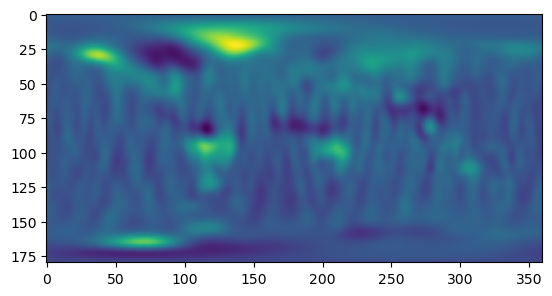

In [14]:
# %%time
tws_fields = tws_cal(delta_sc,lmax,gs,half_rad_gf,no_of_files)
tws_fields = np.float32(tws_fields)

In [15]:
ds = xr.Dataset(
    data_vars=dict(
        tws=(["time","lat", "lon"], tws_fields)
    ),
    coords = {
        "time":(('time'),dates),
        "lat":lat,
        "lon":lon },
    attrs=dict(description="TWS Anomaly corresponding to long term (2004-2010) mean \n lmax=96 and half radius of Gaussian filter = 500Km"),
)
ds

<xarray.Dataset>
Dimensions:  (time: 201, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 2002-04-04 2002-05-02 ... 2022-06-01
  * lat      (lat) int32 89 88 87 86 85 84 83 82 ... -84 -85 -86 -87 -88 -89 -90
  * lon      (lon) int32 -180 -179 -178 -177 -176 -175 ... 175 176 177 178 179
Data variables:
    tws      (time, lat, lon) float32 -2.598 -2.549 -2.499 ... 124.2 124.4 124.6
Attributes:
    description:  TWS Anomaly corresponding to long term (2004-2010) mean \n ...

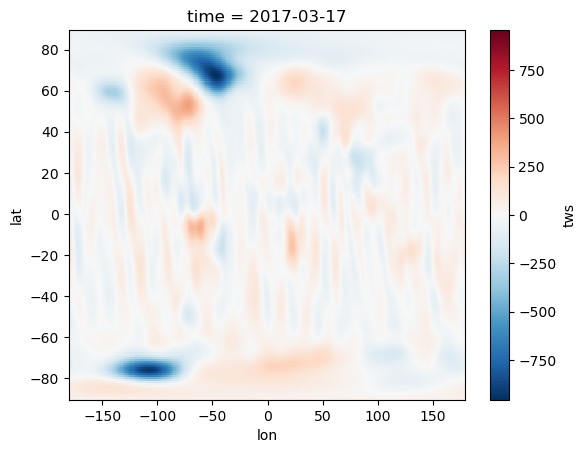

In [16]:
ds.tws.isel(time=150).plot()

In [17]:
ds.time.isel(time=114)

<xarray.DataArray 'time' ()>
array('2012-12-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2012-12-01

In [ ]:
ds.to_netcdf(path_output+'/'+source+'_tws.nc', engine="netcdf4")

## Basin average

In [32]:
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping

<Axes: >

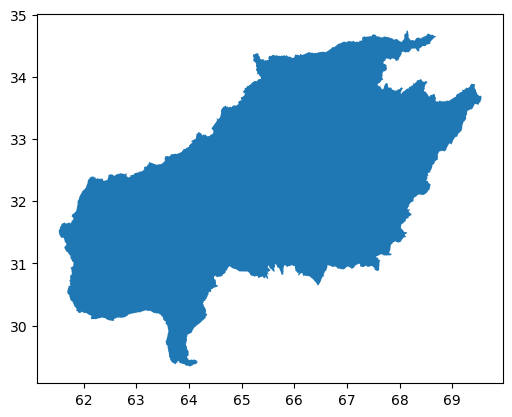

In [21]:
# import shapefile
# using HydroBasins shapefile 
# path = '/home/wslvivek/Desktop/level2/pysh_v2/validation/shapefiles/mrb_shp_zip/mrb_basins.shp'
# path='/home/wslvivek/Desktop/level2/pysh_v2/validation/shapefiles/hybas_as_lev01-12_v1c/hybas_as_lev04_v1c.shp'
path = r"C:\Users\arind\Desktop\vivek_downloads\shp_hel\shp_hel.shp"
shp = gpd.read_file(path)
shp.plot()  

In [22]:
shp.head()

,SUB_AREA,COAST,PFAF_ID,DIST_MAIN,DIST_SINK,HYBAS_ID,NEXT_DOWN,ORDER,ENDO,MAIN_BAS,SORT,NEXT_SINK,UP_AREA,geometry
0,213875.9,0,2914,0.0,0.0,2040085530,0,1,2,2040085530,201,2040085530,213875.9,"POLYGON ((61.52438 31.52426, 61.52575 31.53670..."


Basin area is : 213875900000.0 m²


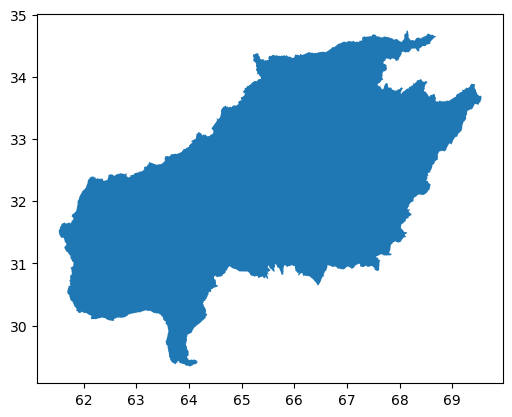

In [23]:
# shp_hel=shp[shp['HYBAS_ID']==2040085530]
# print(shp_hel.head())
shp_hel = shp;
shp_hel.plot()
basin_area=np.float64(shp_hel['SUB_AREA'])*1e6 # basin area already in m^2
print('Basin area is :', basin_area, 'm\u00b2');

In [27]:
''' Area weighting '''
# Calculation of area of each corresponding to  the latitudes and longitudes
deg = 1;
x = np.linspace(0, 359+(1-deg), int(360/deg), dtype='double');
y = np.linspace(0, 179+(1-deg), int(180/deg), dtype='double');
x1 = np.linspace(1*deg, 360, int(360/deg), dtype='double');
y1 = np.linspace(1*deg, 180, int(180/deg), dtype='double');
lambd,theta = np.meshgrid(x,y)  
lambd1,theta1 = np.meshgrid(x1,y1)  
a = np.sin(np.deg2rad(90-theta))-np.sin(np.deg2rad(90-theta1))
b = (lambd1 - lambd)*np.pi/180


# Area of each grid (360*720)
area = (6378.137**2)*pow(10,6)*(np.multiply(a,b))        # units m^2

In [28]:
temp_csr = ds*area
# temp_csr

In [34]:
# clip data using shapefile
''' add projection system to nc '''
basin_tws = temp_csr.rio.write_crs("EPSG:4326", inplace=True)
basin_tws = basin_tws.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
        
# mask data with shapefile
basin_tws = basin_tws.rio.clip(shp.geometry.apply(mapping), shp.crs,drop=False)
basin_avg_tws=basin_tws.sum(dim=('lon','lat'))/basin_area  #basin average tws


# this to remove the WGS84 grid mapping so I can save the file, don't do this for basin scale avg time series
# basin_tws2 = basin_tws.reset_coords(names='WGS84', drop=True)
# del basin_tws2.attrs['grid_mapping']
# basin_tws2

In [37]:
basin_tws

<xarray.Dataset>
Dimensions:      (time: 201, lat: 180, lon: 360)
Coordinates:
  * time         (time) datetime64[ns] 2002-04-04 2002-05-02 ... 2022-06-01
  * lat          (lat) int32 89 88 87 86 85 84 83 ... -85 -86 -87 -88 -89 -90
  * lon          (lon) int32 -180 -179 -178 -177 -176 ... 175 176 177 178 179
    spatial_ref  int32 0
Data variables:
    tws          (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    description:  TWS Anomaly corresponding to long term (2004-2010) mean \n ...

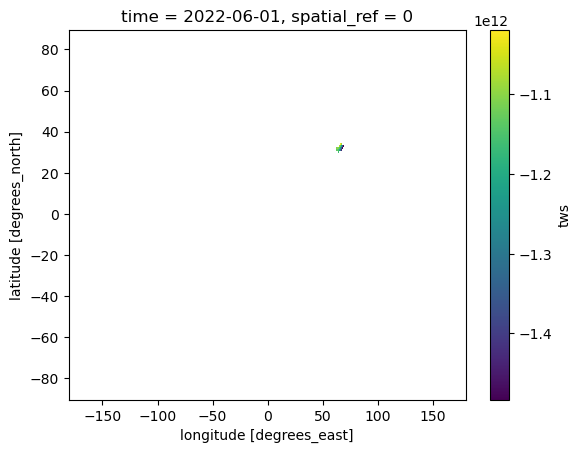

In [38]:
basin_tws.tws.isel(time=-1,).plot()

In [40]:
import matplotlib.pyplot as plt

In [43]:
basin_avg_tws

<xarray.Dataset>
Dimensions:      (time: 201)
Coordinates:
  * time         (time) datetime64[ns] 2002-04-04 2002-05-02 ... 2022-06-01
    spatial_ref  int32 0
Data variables:
    tws          (time) float64 -9.043 12.48 -40.37 ... -86.54 -112.2 -118.9

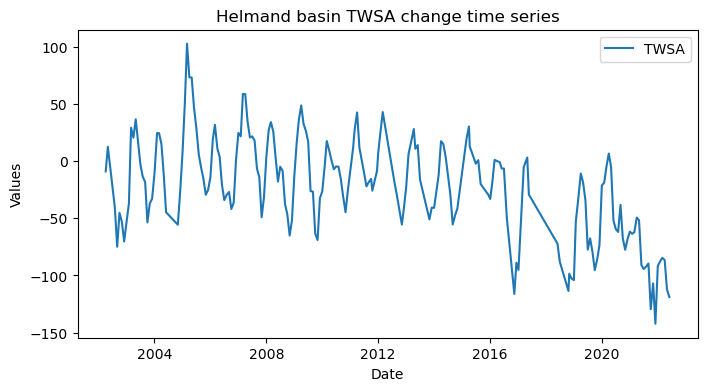

In [44]:
# Create the basin avg time-series plot
plt.figure(figsize=(8, 4))
plt.plot(basin_avg_tws.time, basin_avg_tws.tws.values, label='TWSA')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Helmand basin TWSA change time series')
plt.legend()
plt.show()